# PCA for fault detection in Tennessee Eastman Process

In this notebook, the application of monitoring techniques is demonstrated, using data from the Tennessee Eastman Process benchmark.

In [1]:
import bibmon
import pandas as pd
import matplotlib.pyplot as plt

## Process description

The Tennessee Eastman Process (TEP) is a realistic simulation of a process from Eastman Chemical Company, introduced as a benchmark for process control and monitoring applications ([Downs and Vogel, 1993](https://doi.org/10.1016/0098-1354(93)80018-I)). The academic community has broadly embraced the TEP model for modeling studies, and it is now considered the most widely used benchmark for evaluating process monitoring techniques ([MELO et al., 2022](https://doi.org/10.1016/j.compchemeng.2022.107964)).

The TEP flowsheet is shown below. The objective of the process is to produce two products (G and H) from four reactants (A, C, D, and E), with the presence of an inert substance (B) and a by-product (F) within the process streams. The reactants A, C, D, and E, along with the inert B, are introduced into a stirred tank reactor, where the desired products G and H, as well as the by-product F, are generated. The resulting product stream then goes through a condenser followed by a vapor-liquid separator. Components that do not condense are recycled using a centrifugal compressor, while the condensate moves through a stripper, with the final products being collected from the bottom stream. Vapor is purged from the vapor-liquid separator to eliminate the inert substance and the by-product.

<img src="https://raw.githubusercontent.com/gmxavier/TEP-meets-LSTM/master/tep_flowsheet.png" width="900" height="900"/>

The original proposed simulation presumes the existence of 41 measured variables and 12 manipulated variables, with sampling intervals set at 3, 6, and 15 minutes. Below is a list of these variables.

### Manipulated variables

Variable | Description
-------- | -----------
`XMV(1)`  | D Feed Flow (stream 2)            (Corrected Order)
`XMV(2)`  | E Feed Flow (stream 3)            (Corrected Order)
`XMV(3)`  | A Feed Flow (stream 1)            (Corrected Order)
`XMV(4)`  | A and C Feed Flow (stream 4)
`XMV(5)`  | Compressor Recycle Valve
`XMV(6)`  | Purge Valve (stream 9)
`XMV(7)`  | Separator Pot Liquid Flow (stream 10)
`XMV(8)`  | Stripper Liquid Product Flow (stream 11)
`XMV(9)`  | Stripper Steam Valve
`XMV(10)` | Reactor Cooling Water Flow
`XMV(11)` | Condenser Cooling Water Flow
`XMV(12)` | Agitator Speed

### Continuous process measurement

Variable | Description | unit
-------- | ----------- | ----
`XMEAS(1)`  | A Feed  (stream 1)                  | kscmh
`XMEAS(2)`  | D Feed  (stream 2)                  | kg/hr
`XMEAS(3)`  | E Feed  (stream 3)                  | kg/hr
`XMEAS(4)`  | A and C Feed  (stream 4)            | kscmh
`XMEAS(5)`  | Recycle Flow  (stream 8)            | kscmh
`XMEAS(6)`  | Reactor Feed Rate  (stream 6)       | kscmh
`XMEAS(7)`  | Reactor Pressure                    | kPa gauge
`XMEAS(8)`  | Reactor Level                       | %
`XMEAS(9)`  | Reactor Temperature                 | Deg C
`XMEAS(10)` | Purge Rate (stream 9)               | kscmh
`XMEAS(11)` | Product Sep Temp                    | Deg C
`XMEAS(12)` | Product Sep Level                   | %
`XMEAS(13)` | Prod Sep Pressure                   | kPa gauge
`XMEAS(14)` | Prod Sep Underflow (stream 10)      | m3/hr
`XMEAS(15)` | Stripper Level                      | %
`XMEAS(16)` | Stripper Pressure                   | kPa gauge
`XMEAS(17)` | Stripper Underflow (stream 11)      | m3/hr
`XMEAS(18)` | Stripper Temperature                | Deg C
`XMEAS(19)` | Stripper Steam Flow                 | kg/hr
`XMEAS(20)` | Compressor Work                     | kW
`XMEAS(21)` | Reactor Cooling Water Outlet Temp   | Deg C
`XMEAS(22)` | Separator Cooling Water Outlet Temp | Deg C

### Sampled process measurement

- Reactor Feed Analysis (Stream 6)
  > - Sampling Frequency = 0.1 hr
  > - Dead Time = 0.1 hr
  > - Mole %
  
Variable | Description
-------- | -----------
`XMEAS(23)` | Component A
`XMEAS(24)` | Component B
`XMEAS(25)` | Component C
`XMEAS(26)` | Component D
`XMEAS(27)` | Component E
`XMEAS(28)` | Component F

- Purge Gas Analysis (Stream 9)
  > - Sampling Frequency = 0.1 hr
  > - Dead Time = 0.1 hr
  > - Mole %

Variable | Description
-------- | -----------
`XMEAS(29)` | Component A
`XMEAS(30)` | Component B
`XMEAS(31)` | Component C
`XMEAS(32)` | Component D
`XMEAS(33)` | Component E
`XMEAS(34)` | Component F
`XMEAS(35)` | Component G
`XMEAS(36)` | Component H

- Product Analysis (Stream 11)
  > - Sampling Frequency = 0.25 hr
  > - Dead Time = 0.25 hr
  > - Mole %

Variable | Description
-------- | -----------
`XMEAS(37)` | Component D
`XMEAS(38)` | Component E
`XMEAS(39)` | Component F
`XMEAS(40)` | Component G
`XMEAS(41)` | Component H

### Process faults

The simulation provides 21 pre-programmed disturbances, which include the introduction of step disturbances, modification of measurement variability, occurrence of valve sticking, drift in reaction kinetics and the presence of unknown disturbances. Below is a list of these disturbances.

Disturbance | Description
-------- | -----------
`IDV(1)`  | A/C Feed Ratio, B Composition Constant (Stream 4)          Step
`IDV(2)`  | B Composition, A/C Ratio Constant (Stream 4)               Step
`IDV(3)`  | D Feed Temperature (Stream 2)                              Step
`IDV(4)`  | Reactor Cooling Water Inlet Temperature                    Step
`IDV(5)`  | Condenser Cooling Water Inlet Temperature                  Step
`IDV(6)`  | A Feed Loss (Stream 1)                                     Step
`IDV(7)`  | C Header Pressure Loss - Reduced Availability (Stream 4)   Step
`IDV(8)`  | A, B, C Feed Composition (Stream 4)            Random Variation
`IDV(9)`  | D Feed Temperature (Stream 2)                  Random Variation
`IDV(10)` | C Feed Temperature (Stream 4)                  Random Variation
`IDV(11)` | Reactor Cooling Water Inlet Temperature        Random Variation
`IDV(12)` | Condenser Cooling Water Inlet Temperature      Random Variation
`IDV(13)` | Reaction Kinetics                                    Slow Drift
`IDV(14)` | Reactor Cooling Water Valve                            Sticking
`IDV(15)` | Condenser Cooling Water Valve                          Sticking
`IDV(16)` | Unknown
`IDV(17)` | Unknown
`IDV(18)` | Unknown
`IDV(19)` | Unknown
`IDV(20)` | Unknown

Typically, when the TEP benchmark is used for process monitoring applications, the goal is to develop a method for real-time detection and diagnosis of these disturbances.

For more details on the TEP process, please refer to the following article: [https://doi.org/10.1016/j.compchemeng.2022.107964](https://doi.org/10.1016/j.compchemeng.2022.107964).

## Importing data

The TEP simulation data originally provided by [Chiang et al. (2000)](https://books.google.com/books?hl=pt-BR&lr=&id=G71zWeHzg2QC&oi=fnd&pg=PA1&ots=jTMxhd5OsG&sig=Kp14U3gjLfq8DxKi0Gw5Tpb8RaQ) can be imported into the library using the `load_tennessee_eastman` function. This function requires an argument to specify the nature of data: use 0 for normal operation data and values from 1 to 20 for various process disturbances. Below, we demonstrate how to import normal operation data for training purposes and data corresponding to disturbance event `IDV(1)` for testing. In this dataset, disturbances are introduced after 8 hours of operation. By convention, normal datasets start on `2020-01-01 00:00:00` and faulty datasets start on `2020-02-01 00:00:00`.

In [2]:
df_train, df_test = bibmon.load_tennessee_eastman(train_id = 0, test_id = 1)

fault_start = '2020-02-01 08:00:00'

Let's visualize the datasets to gain insights into the types of behaviors we are modeling (normal data) and attempting to detect (faulty data):

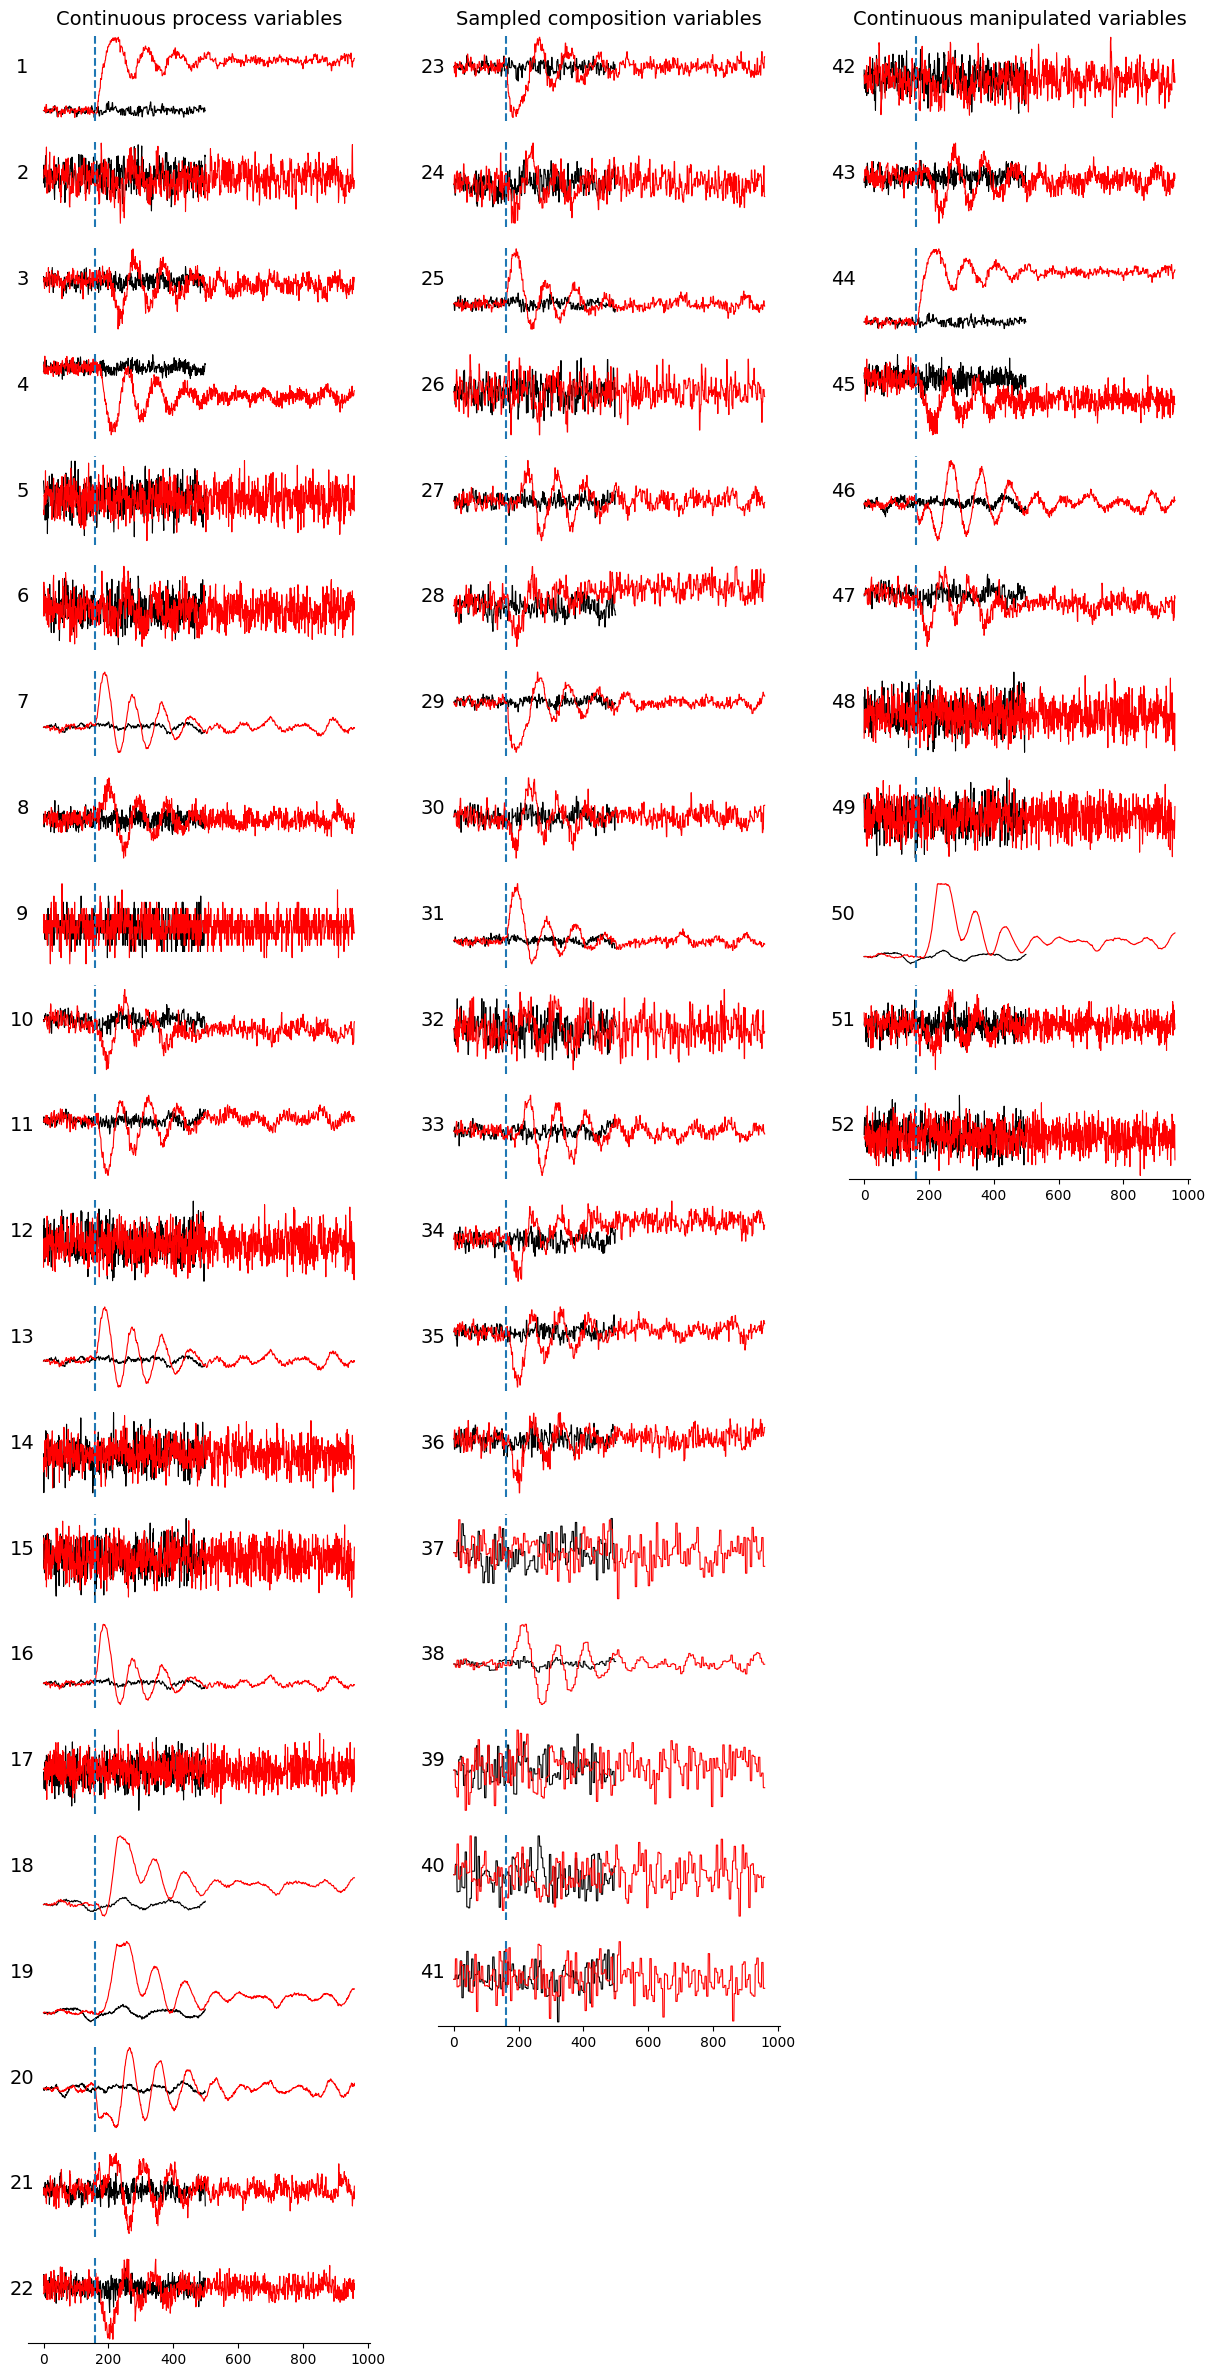

In [3]:
def plot_tep_fault(df_train, df_test):
            
    fig, ax = plt.subplots(22, 3, figsize=(15, 30))

    for i in range(22):
        ax[i,0].plot(df_train.iloc[:,i].values,c='k',linewidth=0.8)
        ax[i,0].plot(df_test.iloc[:,i].values,c='r',linewidth=0.8)
        ax[i,0].axvline(160, ls='--')
        ax[i,0].set_yticks([])
        ax[i,0].set_ylabel(i+1,rotation=0,fontsize=14)
        for j in range(3):
            ax[i,j].spines["top"].set_visible(False)
            ax[i,j].spines["right"].set_visible(False)
            ax[i,j].spines["left"].set_visible(False)
        if i<(22-1):
            ax[i,0].set_xticks([])
            ax[i,0].spines["bottom"].set_visible(False)

    for i in range(19):
        ax[i,1].plot(df_train.iloc[:,i+22].values,c='k',linewidth=0.8)
        ax[i,1].plot(df_test.iloc[:,i+22].values,c='r',linewidth=0.8)
        ax[i,1].axvline(160, ls='--')
        ax[i,1].set_yticks([])
        ax[i,1].set_ylabel(i+23,rotation=0,fontsize=14)
        if i!=(19-1):
            ax[i,1].set_xticks([])
            ax[i,1].spines["bottom"].set_visible(False)

    for i in range(11):
        ax[i,2].plot(df_train.iloc[:,i+41].values,c='k',linewidth=0.8)
        ax[i,2].plot(df_test.iloc[:,i+41].values,c='r',linewidth=0.8)
        ax[i,2].axvline(160, ls='--')
        ax[i,2].set_yticks([])
        ax[i,2].set_ylabel(i+42,rotation=0,fontsize=14)
        if i!=(11-1):
            ax[i,2].set_xticks([])
            ax[i,2].spines["bottom"].set_visible(False)

    for i in range(19,22):
        ax[i,1].axis('off')

    for i in range(11,22):
        ax[i,2].axis('off')

    ax[0,0].set_title('Continuous process variables',fontsize=14)
    ax[0,1].set_title('Sampled composition variables',fontsize=14)
    ax[0,2].set_title('Continuous manipulated variables',fontsize=14);

plot_tep_fault(df_train, df_test)

In the plot above, normal data is represented by black lines, while faulty data is indicated by red lines. The onset of the event, marked by a step change in the A/C feed ratio, is shown as a vertical blue dashed line. Observe that following the onset of the event, the variable values deviate from their normal ranges, exhibit an oscillatory pattern due to the automatic process control loop, and eventually stabilize. For some variables, stabilization occurs within the same range, whereas for others, it occurs in different ranges.

## Modeling and process monitoring

### The PCA model

The model discussed in this tutorial is Principal Component Analysis (PCA), a widely used technique in fault detection and diagnosis for process systems engineering applications. PCA generates a set of orthogonal linear combinations of the original variables, aiming to select a subset of these combinations that effectively captures and summarizes the data's variability. It achieves this by ordering the principal components based on the amount of variability they explain. The first principal component represents the direction with the greatest data variation, while the second principal component is orthogonal to the first, and this pattern continues for subsequent components. A subset of these principal components is then chosen to adequately summarize the data's variability, a process known as dimensionality reduction. 

The following figure illustrates this procedure using a bidimensional example dataset. In the first plot, the red arrows represent the two principal components, with the larger arrow indicating the first principal component, which is associated with the direction of higher data variability. The second plot demonstrates the linear transformation applied by PCA, which is simply a rotation to position the first principal component in the direction of the x-axis. The third plot shows the dimensionality reduction step, where the bidimensional data is transformed into a unidimensional representation, eliminating the second dimension. Finally, the last plot depicts the reconstruction process, in which the data is projected back into the original bidimensional space, but now with variation only along the direction of the first principal component.

![PCA Visualization](https://www.mdpi.com/processes/processes-12-00251/article_deploy/html/images/processes-12-00251-g001-550.jpg)

When PCA is applied to fault detection, the principal components are selected using the training data. These principal components are expected to explain the variability of the test data as well. If the test data's variability is not adequately explained by the principal components identified during training, the process is considered to be faulty and alarms are trigged.

For more details on the PCA model, please refer to the following article: https://doi.org/10.3390/pr12020251.

### Training the model

The following command instantiates a BibMon's PCA model:

In [4]:
model = bibmon.PCA()

To train the model, we use the `fit` method:

In [5]:
model.fit(df_train)

The fault detection index used by BibMon is the Squared Prediction Error (SPE). This index is based on the difference between the measured data, $\mathbf{X}$, and the data reconstructed by the model, $\mathbf{\hat{X}}$:

$$ \text{SPE}_i = \sum_{j} (X_{ij} - \hat{X}_{ij})^2 $$

The higher the SPE values, the greater the likelihood that the captured PCA model does not adequately explain the variability in the data, indicating that the process is not in its normal state.

Let's create a control chart of SPE values for the training data:

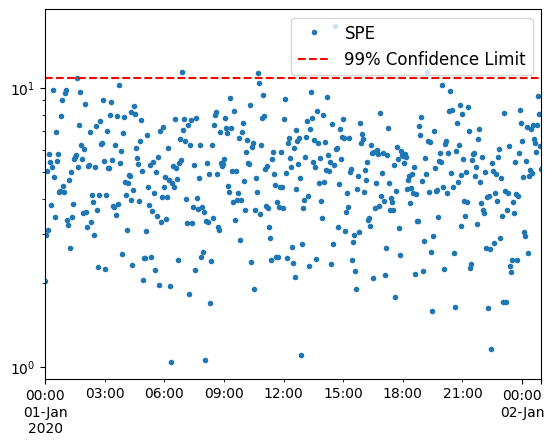

In [6]:
model.plot_SPE(train_or_test = 'train')

The confidence limit is established to ensure that 99% of the training SPE points fall below it. If new data points exceed this limit, it indicates a deviation from normal operation, triggering alarms.

Overfitting to the training data often leads to an underestimation of the confidence limit. To mitigate this, we can reserve a portion of the data at the end of the time series exclusively for setting the limit, rather than using it for training. This practice generally raises the limit and reduces false alarm rates. To implement this, we set the `redefine_limit` parameter to `True`, and the fraction of data reserved is specified by the `frac_val` parameter:

In [7]:
model.fit(df_train, redefine_limit = True, frac_val = 0.1)

Another useful visualization is the explained variance identified by the model:

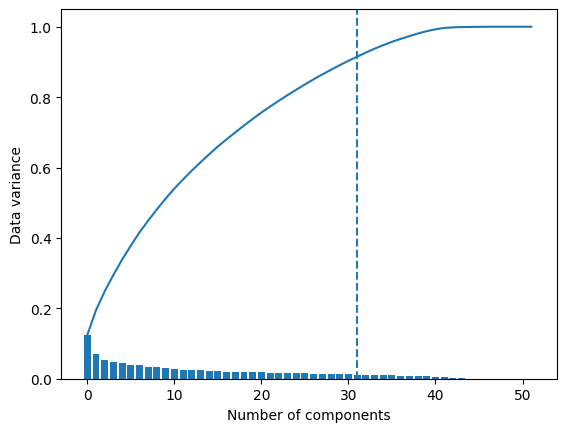

In [8]:
model.plot_cumulative_variance()
plt.gca().axvline(model.n,ls='--');

In the above plot, bars represent the data variance captured by each component, while the continuous line shows the cumulative variance. The vertical dashed line indicates the number of principal components retained by the model. By default, this number is set to ensure that these components together account for 90% of the variability in the data.

### Applying the model to test data

To apply the model to a test dataset, we use the function `predict`:

In [9]:
model.predict(df_test)

Let's plot the SPE chart for the test:

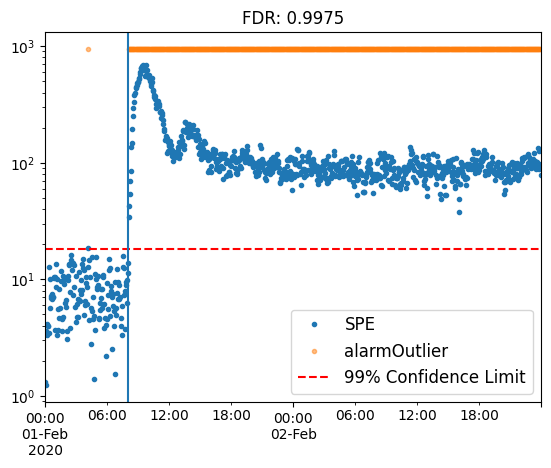

In [10]:
model.plot_SPE(train_or_test = 'test')
plt.gca().axvline(fault_start);
plt.title(f'FDR: {model.alarmOutlier[fault_start:].mean()}');

Observe how the SPE points rapidly increase as the faulty event begins, surpassing the confidence limit and triggering alarms, which are represented by the orange points. The fault detection rate (FDR) exceeds 99%, demonstrating the high capability of PCA in detecting this type of fault.

## Analyzing the effect of preprocessing techniques

In `BibMon`, applying preprocessing techniques is straightforward: simply define lists with the names of the functions in the desired order of application, and provide them to the `fit` and `predict` methods.

In the TEP process, specifically in the `IDV-11` case, the fault detection rate improves with the application of noise filtering techniques and the addition of dynamics through lags.

In [11]:
df_train, df_test = bibmon.load_tennessee_eastman(train_id = 0, test_id = 11)

### Using the default pre-processing pipeline

The default preprocessing pipeline is as follows:

- training: `['remove_empty_variables', 'ffill_nan', 'remove_frozen_variables', 'normalize']`;
- test: `['replace_nan_with_values', 'normalize']`.

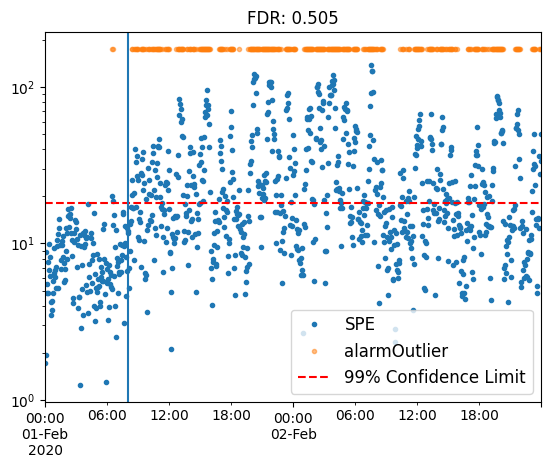

In [12]:
model = bibmon.PCA()

model.fit(df_train, redefine_limit = True, frac_val = 0.1)

model.predict(df_test)

model.plot_SPE(train_or_test = 'test')
plt.gca().axvline(fault_start);
plt.title(f'FDR: {model.alarmOutlier[fault_start:].mean()}');

### Applying lag

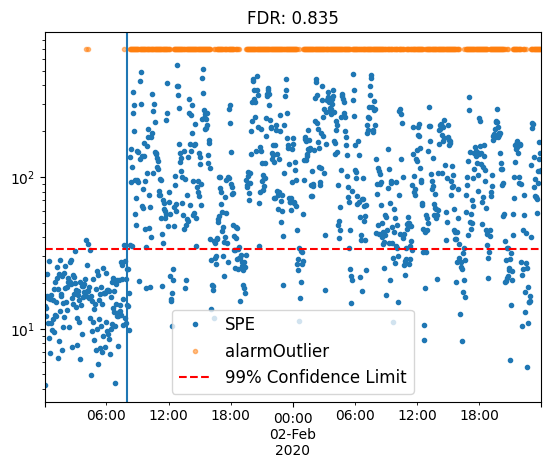

In [13]:
model = bibmon.PCA()

preproc = ['apply_lag', 'normalize']

model.fit(df_train, f_pp = preproc, f_pp_test = preproc, redefine_limit = True, frac_val = 0.1)

model.predict(df_test)

model.plot_SPE(train_or_test = 'test')
plt.gca().axvline(fault_start);
plt.title(f'FDR: {model.alarmOutlier[fault_start:].mean()}');

Notice how the `normalize` method was added to the pipeline, as it is essential prior to applying PCA modeling.

### Applying a moving average filter

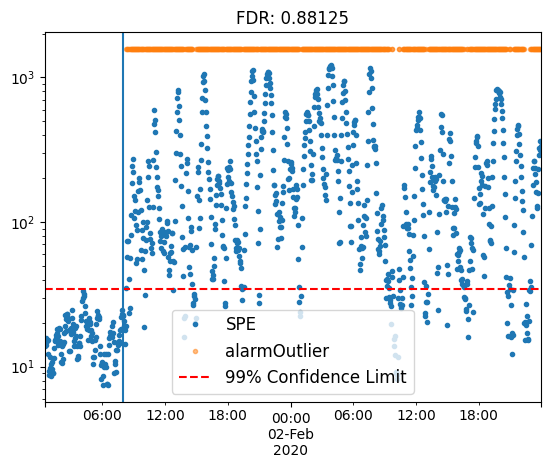

In [14]:
model = bibmon.PCA()

preproc = ['moving_average_filter', 'normalize']

model.fit(df_train, f_pp = preproc, f_pp_test = preproc, redefine_limit = True, frac_val = 0.1)

model.predict(df_test)

model.plot_SPE(train_or_test = 'test')
plt.gca().axvline(fault_start);
plt.title(f'FDR: {model.alarmOutlier[fault_start:].mean()}');

### Applying filter and lag, modifying parameters using the `args_preproc` argument

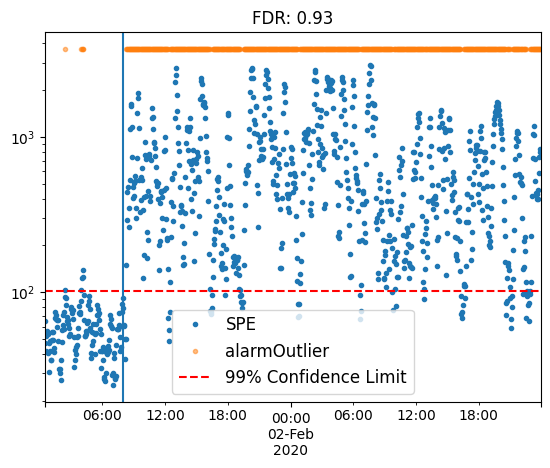

In [15]:
model = bibmon.PCA()

preproc = ['apply_lag', 'moving_average_filter', 'normalize']
args_preproc = {'moving_average_filter__WS': 5, 'apply_lag__lag': 5}

model.fit(df_train, f_pp = preproc, a_pp = args_preproc,
          f_pp_test = preproc, a_pp_test = args_preproc,
          redefine_limit = True, frac_val = 0.1)

model.predict(df_test)

model.plot_SPE(train_or_test = 'test')
plt.gca().axvline(fault_start);
plt.title(f'FDR: {model.alarmOutlier[fault_start:].mean()}');

By employing various preprocessing techniques, we can boost fault detection rates from a baseline of 50.5% to 93%.

## Final considerations

This notebook provides an example of an offline monitoring study utilizing the PCA model.

For a demonstration of `BibMon`'s high-level functions, which allow for the rapid execution of a complete process monitoring pipeline for analysis and methodology comparison, please refer to the `tutorial_real_process.ipynb` notebook.